This lab session in an introduction to feed-forward and convolutional neural network with pytorch. We use the dataset Fashion-MNIST (see for more details this website https://github.com/zalandoresearch/fashion-mnist). The dataset contains 60000 and 10000 images for respectively training and testing. Each image is 28x28 pixels, for a total of 784 per image.  An image is presented to the neural network as a flat vector of 784 component.

First load and test python and pytorch. Your notebook is supposed to work with python 3 (see the top right corner of the notebook).

In [1]:
# math, numpy and plot
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
# torch
import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# gzip
import gzip
import pickle


In [2]:

# Load the dataset for the training/validation sets
valid_ratio = 0.3
dataset_dir = "./"
train_valid_dataset = datasets.FashionMNIST(root=dataset_dir,
                                           train=True,
                                           transform= ToTensor(),
                                           download=True)

# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = th.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])



100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.97MB/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
len(train_dataset)

42000


In pytorch data handling is done in 2 steps:
- `DataSet`: a class to access the raw data, it can be tensors, files, distributed files, ...
- `DataLoader` (the class to iterate through the dataset and to get access to well prepared batch of data)

From the model viewpoint:
- During training and testing the model interacts with the `DataLoader` to go through the `DataSet`
- The Dataloader pick what is necessary in the `DataSet`  

Here we already have dataset.

To look at one batch :

In [47]:
batch_size =2000
trainloader =  DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True )
batch_size =2000
validloader =  DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False )


In [18]:
batch = next(iter(trainloader))
# Explore what you get as a batch
print(type(batch),len(batch))
print(type(batch[0]),type(batch[1]))
print(batch[0].shape,batch[1].shape)

<class 'list'> 2
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1000, 1, 28, 28]) torch.Size([1000])


tensor(0)


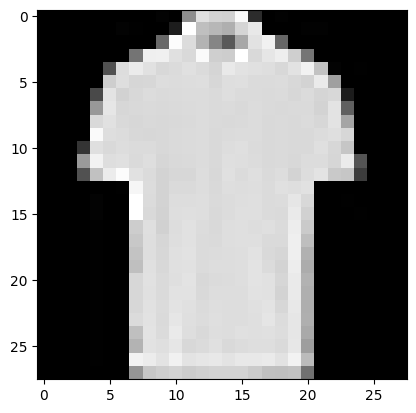

In [19]:
i = 1
image = batch[0][i]
label = batch[1][i]
plt.imshow(image.squeeze().numpy() , matplotlib.pyplot.cm.gray)
print(label)

In [20]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}



In [21]:
print(labels_map[label.item() ])

T-shirt


# Feed forward neural network



A feedforward model can rely on the pytorch module *Sequential*.
A *Sequential* module is a container of ordered modules: the first one takes input data and its output is given to feed the second module, and so on.

**Note:** In pytorch, modules assumed Tensors as input. The input Tensor can contain just one input (online mode) or several inputs (mini-batch). The first dimension of the input Tensor corresponds to the mini-batch, and the second one to the dimension of the example to feed in. For example, with a mini-batch of size B and an image of D pixels, the input Tensor should be of shape (B,D), even if B=1 for one exemple.


## Shallow network

Let start with a simple model with one input layer and one output layer (without hidden layers). Please refer to the examples provided previously, and propose an implementation of this linear model using the *Sequential* module as container.  To write the model, we must consider the fact that the model is trained in order to maximize the Log-likelihood on the training data. If you look at  https://pytorch.org/docs/stable/nn.html, the documentation of the NNet package of pytorch, there is a section on the loss functions.

Two of the proposed loss function can be used for our purpose. The choice of one of them implies the choice of the activation function at the output layer.

- What are these two possible choices ?
- Make a choice and replace the "None" in the following cell

In [22]:
D_in = 784
D_out= 10

model =  nn.Sequential(
    nn.Linear(D_in,D_out),
    nn.LogSoftmax(dim=1)
)
loss_function = nn.NLLLoss()

image = image.view(1,-1)

preds = model(image)
print(preds.shape)
print(preds[0])
loss = loss_function(preds.squeeze(), label)
print("prediction du modele :", th.argmax(preds))
print("label ",label)
print("la loss", loss)



torch.Size([1, 10])
tensor([-2.2625, -1.7718, -2.5837, -1.8775, -2.6348, -2.4695, -2.8148, -2.5761,
        -2.2312, -2.3261], grad_fn=<SelectBackward0>)
prediction du modele : tensor(1)
label  tensor(0)
la loss tensor(2.2625, grad_fn=<NllLossBackward0>)


- Can you explain what we observe ?
- Do it the same for one batch and explain what you observe.


In [52]:
def train(model, maxepoch=10,lr=1e-3):
    device="cpu"
    if th.cuda.is_available():
      device="cuda"
    print("on est sur ",device)
    model=model.to(device)
    opt = th.optim.Adam(model.parameters(), lr=lr)
    trainloss = np.zeros(maxepoch)
    validloss = np.zeros(maxepoch)
    accuracy = np.zeros(maxepoch)
    validaccuracy = np.zeros(maxepoch)
    lossf = nn.NLLLoss()
    for i in range(maxepoch):
        for batch in trainloader:
            # 1/ inference
            X,Y = batch
            X , Y = X.to(device), Y.to(device)
            B,C,H,W = X.shape
            ypred = model.forward(X.view(B,H*W))
            # 2/ calculer le cout
            # Attention, ypred et Y doivent avoir la même taille !
            l = lossf(ypred.squeeze(), Y) #####################
            trainloss[i] += l.item()
            accuracy[i]+=(ypred.argmax(dim=-1) == Y).sum()
            # 3/ backprop
            l.backward()
            # 4/ Update
            opt.step()
            # maintenance
            opt.zero_grad()
        for batch in validloader:
            X,Y = batch
            X , Y = X.to(device), Y.to(device)
            B,C,H,W = X.shape
            ypred = model.forward(X.view(B,H*W))
            # 2/ calculer le cout
            # Attention, ypred et Y doivent avoir la même taille !
            l = lossf(ypred.squeeze(), Y) #####################
            validloss[i] += l.item()
            validaccuracy[i]+=(ypred.argmax(dim=-1) == Y).sum()
        print(i, trainloss[i], accuracy[i]*100/nb_train, "||" ,
              validloss[i], validaccuracy[i]*100/nb_valid)
    plt.plot(trainloss)
    plt.plot(validloss)


on est sur  cuda
0 35.08657145500183 53.00238095238095 || 10.917291402816772 65.47222222222223
1 21.851677775382996 68.04047619047618 || 8.359056830406189 69.56666666666666
2 18.075677573680878 72.1547619047619 || 7.371898531913757 73.14444444444445
3 16.291456878185272 75.08095238095238 || 6.810812294483185 75.57222222222222
4 15.165548145771027 77.07619047619048 || 6.398706674575806 77.16111111111111
5 14.3224555850029 78.5547619047619 || 6.0952383279800415 78.14444444444445
6 13.677230834960938 79.41666666666667 || 5.85862523317337 78.96666666666667
7 13.177192032337189 80.12380952380953 || 5.659717381000519 79.59444444444445
8 12.759160578250885 80.61904761904762 || 5.501338958740234 80.16111111111111
9 12.388758838176727 81.23095238095237 || 5.369839012622833 80.72222222222223


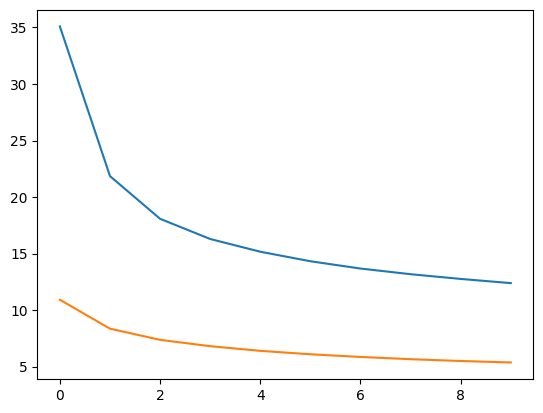

In [53]:
model =  nn.Sequential(
    nn.Linear(D_in,D_out),
    nn.LogSoftmax(dim=1)
)

train(model)

on est sur  cuda
0 26.088844776153564 61.03809523809524 || 6.589571118354797 73.31111111111112
1 13.013832211494446 78.16428571428571 || 5.014894902706146 79.39444444444445
2 10.510731518268585 82.1047619047619 || 4.3436020612716675 82.89444444444445
3 9.406297832727432 83.93333333333334 || 4.017525553703308 84.17777777777778
4 8.717362523078918 85.1547619047619 || 3.791236847639084 85.31111111111112
5 8.34094163775444 85.69285714285714 || 3.683750957250595 85.74444444444444
6 8.008756577968597 86.43333333333334 || 3.7373175621032715 85.33888888888889
7 7.778009444475174 86.68095238095238 || 3.486891657114029 86.23333333333333
8 7.43929922580719 87.32142857142857 || 3.4427847266197205 86.50555555555556
9 7.240093290805817 87.69285714285714 || 3.3537587225437164 86.9
10 7.0639245212078094 87.9095238095238 || 3.4058805406093597 86.64444444444445
11 6.907651752233505 88.25714285714285 || 3.2587776482105255 87.03888888888889
12 6.662068843841553 88.62857142857143 || 3.1958836019039154 87.3

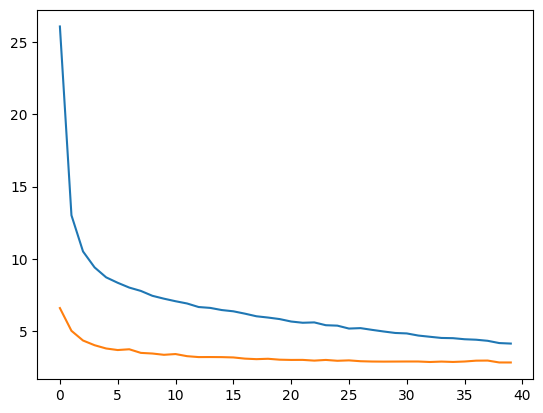

In [56]:
H = 200
model =  nn.Sequential(
    nn.Linear(D_in,H),
    nn.Sigmoid(),
    nn.Linear(H,D_out),
    nn.LogSoftmax(dim=1)
)

train(model,maxepoch=40,lr=5e-3)

on est sur  cuda
0 34.8654043674469 48.92619047619048 || 9.273454189300537 61.28333333333333
1 17.346456050872803 69.13809523809523 || 6.032127797603607 74.77777777777777
2 12.19349604845047 78.53333333333333 || 4.745858252048492 80.77222222222223
3 10.05339139699936 82.86428571428571 || 4.199461877346039 83.77777777777777
4 8.857008695602417 84.98571428571428 || 3.850174218416214 84.95
5 8.15365731716156 86.10952380952381 || 3.702620804309845 85.33333333333333
6 7.781703740358353 86.70476190476191 || 3.5552192330360413 85.81666666666666
7 7.363800019025803 87.42142857142858 || 3.3816190361976624 86.58888888888889
8 7.090681493282318 87.86190476190477 || 3.2920792400836945 86.80555555555556
9 6.774532645940781 88.45238095238095 || 3.230650246143341 87.11111111111111
10 6.574144333600998 88.81904761904762 || 3.2344416975975037 86.94444444444444
11 6.450245141983032 88.93571428571428 || 3.1424858570098877 87.3
12 6.227249920368195 89.21904761904761 || 3.082872688770294 87.60555555555555


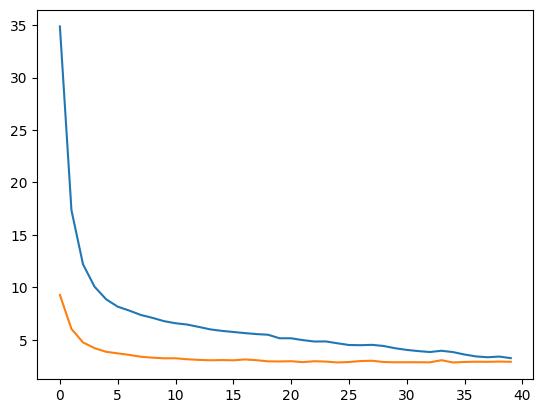

In [57]:
H1, H2 = 200, 100
model =  nn.Sequential(
    nn.Linear(D_in,H1),
    nn.Sigmoid(),
    nn.Linear(H1,H2),
    nn.Sigmoid(),
    nn.Linear(H2,D_out),
    nn.LogSoftmax(dim=1)
)

train(model,maxepoch=40,lr=5e-3)

on est sur  cuda
0 32.59029895067215 54.15952380952381 || 8.08201938867569 67.58333333333333
1 15.627286732196808 72.06190476190476 || 5.910137116909027 75.90555555555555
2 12.560177266597748 79.12619047619047 || 5.107978105545044 80.35
3 11.1189284324646 81.52142857142857 || 4.649281620979309 82.38333333333334
4 10.250281989574432 83.02380952380952 || 4.376818060874939 83.05
5 9.710016429424286 83.75 || 4.1663190722465515 83.93888888888888
6 9.22638601064682 84.6547619047619 || 4.026349186897278 84.39444444444445
7 8.918455839157104 85.1547619047619 || 3.92150741815567 84.91666666666667
8 8.655395865440369 85.56666666666666 || 3.8722373843193054 84.7388888888889
9 8.516325980424881 85.59761904761905 || 3.7605093717575073 85.40555555555555
10 8.182909190654755 86.19761904761904 || 3.6875616908073425 85.63888888888889
11 8.056216895580292 86.39047619047619 || 3.6671020090579987 85.60555555555555
12 7.916212499141693 86.61428571428571 || 3.59193554520607 85.90555555555555
13 7.7067989706

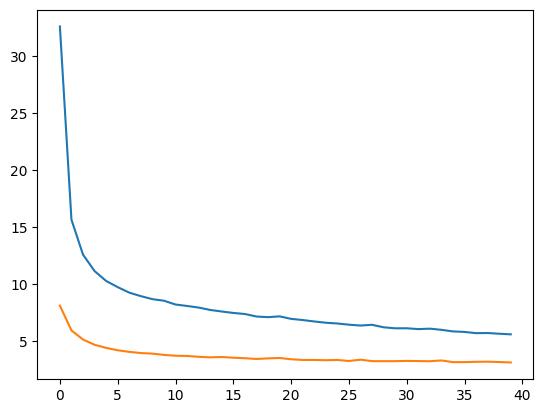

In [59]:
H1, H2 = 200, 100
model =  nn.Sequential(
    nn.Linear(D_in,H1),
    nn.ReLU(),
    nn.Linear(H1,H2),
    nn.ReLU(),
    nn.Linear(H2,D_out),
    nn.LogSoftmax(dim=1)
)

train(model,maxepoch=40,lr=1e-3)

In [31]:
X, Y = next(iter(trainloader))
B,C,H,W = X.shape
X , Y = X.to("cuda"), Y.to("cuda")

ypred= model.forward(X.view(B,H*W))


In [34]:
ypred.argmax(dim=-1)

tensor([0, 2, 9, 8, 0, 4, 6, 8, 0, 4, 5, 2, 5, 6, 8, 4, 4, 7, 9, 9, 3, 1, 6, 3,
        2, 3, 5, 2, 0, 4, 1, 0, 3, 0, 9, 8, 5, 7, 8, 7, 8, 3, 3, 6, 3, 4, 2, 8,
        3, 8, 2, 7, 9, 8, 1, 5, 7, 8, 5, 0, 3, 3, 6, 2, 7, 0, 4, 0, 9, 2, 5, 0,
        2, 2, 8, 4, 9, 2, 5, 2, 9, 5, 4, 3, 4, 1, 5, 6, 7, 1, 9, 7, 4, 3, 7, 9,
        9, 2, 4, 5, 7, 9, 7, 9, 0, 5, 4, 9, 3, 1, 6, 4, 0, 9, 2, 3, 9, 2, 1, 4,
        8, 7, 7, 5, 5, 5, 4, 8, 9, 0, 8, 7, 4, 0, 0, 2, 5, 9, 5, 3, 9, 5, 8, 7,
        6, 7, 4, 0, 2, 4, 4, 0, 8, 8, 1, 6, 0, 0, 9, 8, 8, 5, 0, 9, 7, 9, 5, 0,
        0, 3, 0, 4, 2, 1, 6, 2, 5, 7, 4, 1, 5, 6, 9, 5, 8, 1, 7, 2, 0, 3, 1, 5,
        1, 1, 8, 2, 2, 7, 3, 4, 1, 2, 7, 6, 0, 9, 1, 0, 2, 5, 1, 9, 6, 9, 4, 1,
        8, 5, 0, 3, 3, 0, 4, 7, 0, 6, 4, 6, 9, 1, 3, 9, 6, 4, 3, 8, 5, 8, 7, 4,
        8, 0, 7, 4, 5, 4, 3, 7, 5, 5, 1, 7, 7, 4, 6, 6, 1, 4, 4, 6, 4, 7, 2, 6,
        1, 1, 1, 4, 1, 6, 7, 1, 1, 7, 7, 4, 6, 0, 6, 2, 6, 9, 0, 9, 7, 2, 9, 0,
        4, 8, 2, 1, 2, 8, 4, 3, 8, 5, 0,

- Train the network on the training data and evaluate what happens on developpment data.
- Play with the learning rate.

## MLP training

- Build and train a MLP with one hidden layer. Look at the performance.
- Play with the learning rate.
- Can you estimate the number of parameter and how does it scale with dimensions (image, number of classes, ...)
- Then try to add one more hidden layer.
- And one more ...


# Convolution

The goal is to incrementally build an image classifier based on convolutional layers. Since we consider images and convolution we will use Tensors with peculiar shapes in input. Moreover, this session is also the occasion to introduce "Max-pooling" and "Batch-normalization".




## Dataset

First the dataset !  The provided version is unfortunately not adapted to our purpose in terms of dimensions.
*Convolution2D* expects as input a Tensor with 4 dimensions $(N,C,H,W)$ with :

- N the batch dimension, *i.e* the number of images
- C the number of input channels, here it is 1
- H the height or number of rows of each image
- W the width  or number of columns of each image

## Playing with convolution in 2D

Let start the exploration of convolution.The class we will use is called Conv2d. Read carefully the documentation of this module. Maybe you cannot understand everything. That's why it is useful to first play with the convolution with one image.

In [ ]:
# Extract one image to start and be sure you have the right dimensions.


Now create one convolution layer with 1 input channels, a kernel size of 3, and a stride of 1.
Try it and look at the output dimension.


In [ ]:
# TODO:


The resulting "image" is not of the same dimension, how to obtain an output with the same dimension (same question with a kernel size of 5) ?

In [ ]:
# TODO



## Examples of "handmaid" filters

We can define the parameters of the convolutional filter with our own hands. For that purpose we just have to create the Tensor we want and cast it in a *Parameter* object (usefull for autograd) and then assign it.
This is an example:

In [ ]:
# Create a convolutional filter
convFilter = nn.Conv2d(in_channels=1,out_channels=1,
                       kernel_size = 3, padding=1,
                       stride=1)
# build the weight matrix you want
W=th.ones(convFilter.weight.shape)
# Makes it a Parameter and assign
convFilter.weight = nn.Parameter(W)

res = convFilter(im)
plt.subplot(1,2,1)
plt.imshow(im.squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(F.relu(res).squeeze().detach(), matplotlib.pyplot.cm.gray)

Now try to set the convolution fiter as follows:
$$
\left(
\begin{array}{ccc}
 -1 &2&-1\\
 -1 &2&-1\\
 -1 &2&-1
\end{array}
\right)
$$
and then as follows:
$$
\left(
\begin{array}{rrr}
 -1 &-1&-1\\
 2 &2&2\\
 -1 &-1&-1
\end{array}
\right)
$$
Try them on some images and visualize the results.

In [ ]:
# TODO


# Pool !

Now we introduce the max-pooling in 2 dimensions: *MaxPool2d*. Look at the documentation and then try to define the following pipeline:
- a convolution with a kernel size of 3, stride 1 and padding 1
- apply the ReLu function and
- a max pooling with kernel size of 2 and a stride of 2.
Try to guess before running your code the dimensions of the output !


In [ ]:
# TODO


#  A first model

After this interlude, the goal now is to write a class to implement the model with:

- 2D convolution with (kernel size = 3, padding = 1, stride 1)
- ReLu activation
- Max-pooling (kernel size = 2, stride 2)
- A final linear classifier
- The final activation

Writing this class, allows you to wrap what you have seen so far. To debug the model, you can first play step-by-step with each layer to ensure you obtain the right dimensions (it was done earlier). Then, write the class and run the training to evaluate the result (this what we have to do now).

The class inherits from an existing class of pytorch : *Module*. This mean: it is a *Module*, but we add some peculiarities. For that purpose we can fill the following code:

In [ ]:
# TODO
class FashionCNN(nn.Module):

    def __init__(self, kernel_size = 3, padding= 1, out_channels = 1):
        super(FashionCNN, self).__init__()
        # TODO : write the end of the constructor.
        # It is important to create here all the layers of the network.
        # All layers that have paramaters should be attribute.
        # For example:
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels,
                              kernel_size=kernel_size, padding=padding)
        # TODO: add the rest


    def forward(self, x):
        # TODO
        # if you need to run forward with the conv layer,
        # you can call it by self.conv
        outconv  = self.conv(x)
        # ...
        return output

In [ ]:
# Test the class: is everything in place:
# A first classifier is built like :
classif = FashionCNN()
# The parameters of the classifier are randomly initialize, but we
# can use it on a image :
out = classif.forward(im)
print(out.shape) # the output has 2 dimensions
print(out)

# It is correct ? If not, correct the class to get the expected result.


# Training the model

To train the model, we need to define a loss function and an optimizer. For the moment we will rely on an online learning algorithm: online stochastic gradient descent. Like the previous lab session:
- we pick one training example
- compute the loss
- back-propagation of the gradient
- update of the parameters


At the end of one epoch, we evaluate the model on the validation step. You can use for that purpose the training function we wrote earlier.


To train the CNN, we can reuse the training function you wrote carefully in the previous lab session. However we need to adapt it in order to use dataloaders (the `trainloader` and `validloader`)

Question:
- As optimizer we will use *Adam*. It is important to find the good choice of hyper-parameter for the initial learning rate. Try different values like 0.1, 0.01, ...
- Then try with a number of output channel set to 1, 8, 16.



In [ ]:
# TODO : paste here the training function you wrote before.
# Of course you can improve it if you want during the lab session.
# Especially in terms of parameters.



In [ ]:
# TODO
loss_fn=nn.NLLLoss()
model = FashionCNN()
# Train you model !

## Batch-norm

Extend your model to include the Batch-normalization.


In [ ]:
# TODO


## More convolution

We can now define an extended model where the basic block is : Conv2D, ReLu, BatchNorm and MaxPool.
We stack two blocks of this kind before the classification.

For instance in the previous model, this kind of block reduce the image size and increase the number of output channels. We can try to do the same and double this number in the second block.

TODO:
- Implement a model with two blocks as decribed above.
- We can then improve the output classifier.
- Play with the hyper-parameters.

Of course if you want to leverage a deeper model it is useful to increase the amount of training data (we only take the first 30k images until now).

In [ ]:
# TODO


# And now in color: CIFAR-10


To experiment image classification on a coloured image, we can use the CIFAR-10 dataset.
You can find more details for instance on this page: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. We can download the dataset with a dataloader directly:

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = th.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = th.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

With this example we will use a **dataset** via a *dataloader*.  This is a convenient tool to handle datasets with efficient iterators.

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

# Todo

Implement `VGG 16` architecture to get state of the art performance (see the course for the architecture)